## Import libraries

In [ ]:
import os
import json
import transformers
import datasets
import accelerate
import peft
import torch
import torchvision
import bitsandbytes

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

In [ ]:
#!pip install -q flash-attn --no-build-isolation

## Load Model

In [ ]:
import torch
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model, PeftModel
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration, AutoTokenizer

#for visible devices to be only 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE=0
USE_LORA = False
USE_QLORA = True
SMOL = True

model_id = "HuggingFaceTB/SmolVLM-Base" if SMOL else "HuggingFaceTB/SmolVLM-500M-Instruct" 
processor = AutoProcessor.from_pretrained(model_id)
    

if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    lora_config.inference_mode = False
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )
    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config if USE_QLORA else None,
        _attn_implementation="eager", # "flash_attention_2"
        device_map="cuda:0"
    )
    
    model.add_adapter(lora_config)
    model.enable_adapters()
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    print(model.get_nb_trainable_parameters())
else:
    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        _attn_implementation= "eager", #"flash_attention_2",
    ).to(DEVICE)

    # if you'd like to only fine-tune LLM
    for param in model.model.vision_model.parameters():
        param.requires_grad = False

## Load data

In [4]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="passengers_bus_vlm_dataset_modified.json")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 309
    })
})


In [ ]:
#split the dataset
split_ds = dataset["train"].train_test_split(test_size=0.2, seed=42)  # 80% train, 20% validation
validation_test_split = split_ds["test"].train_test_split(test_size=0.5, seed=42)

train = split_ds["train"]
val = validation_test_split["train"]
test = validation_test_split["test"]
print(f"Train size: {len(train)}, Validation size: {len(val)}, Test size: {len(test)}")

Train size: 247, Validation size: 31, Test size: 31


In [6]:
train

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 247
})

In [7]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
  texts = []
  images = []
  for example in examples:
      image_path = example["image"]
      image = Image.open(image_path)
      if image.mode != 'RGB':
        image = image.convert('RGB')
      question = example["question"]
      answer = example["answer"]
      messages = [
          {"role": "system", "content": "You are a Vision Language Model specialized in extracting data from images.Your task is to analyze the provided image of the inside of a bus and extract the relevant information."},
          {
              "role": "user",
              "content": [
                  {"type": "image"},
                  {"type": "text", "text": question}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": answer}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)
      texts.append(text.strip())
      images.append([image])

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

## Results of fine tuned SmolVLM Model

In [ ]:
#load the finetuned model with adapter for inference
from transformers import AutoTokenizer
output_dir = "smolvlm-finetuned-model"

base_model = Idefics3ForConditionalGeneration.from_pretrained(model_id).to(DEVICE)
model = PeftModel.from_pretrained(base_model, output_dir)
#Merges the LoRA weights into the base model weights, so you now have a standalone model with LoRA weights permanently applied.
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

How many people are sitting?
The number of people sitting in the bus is 27.


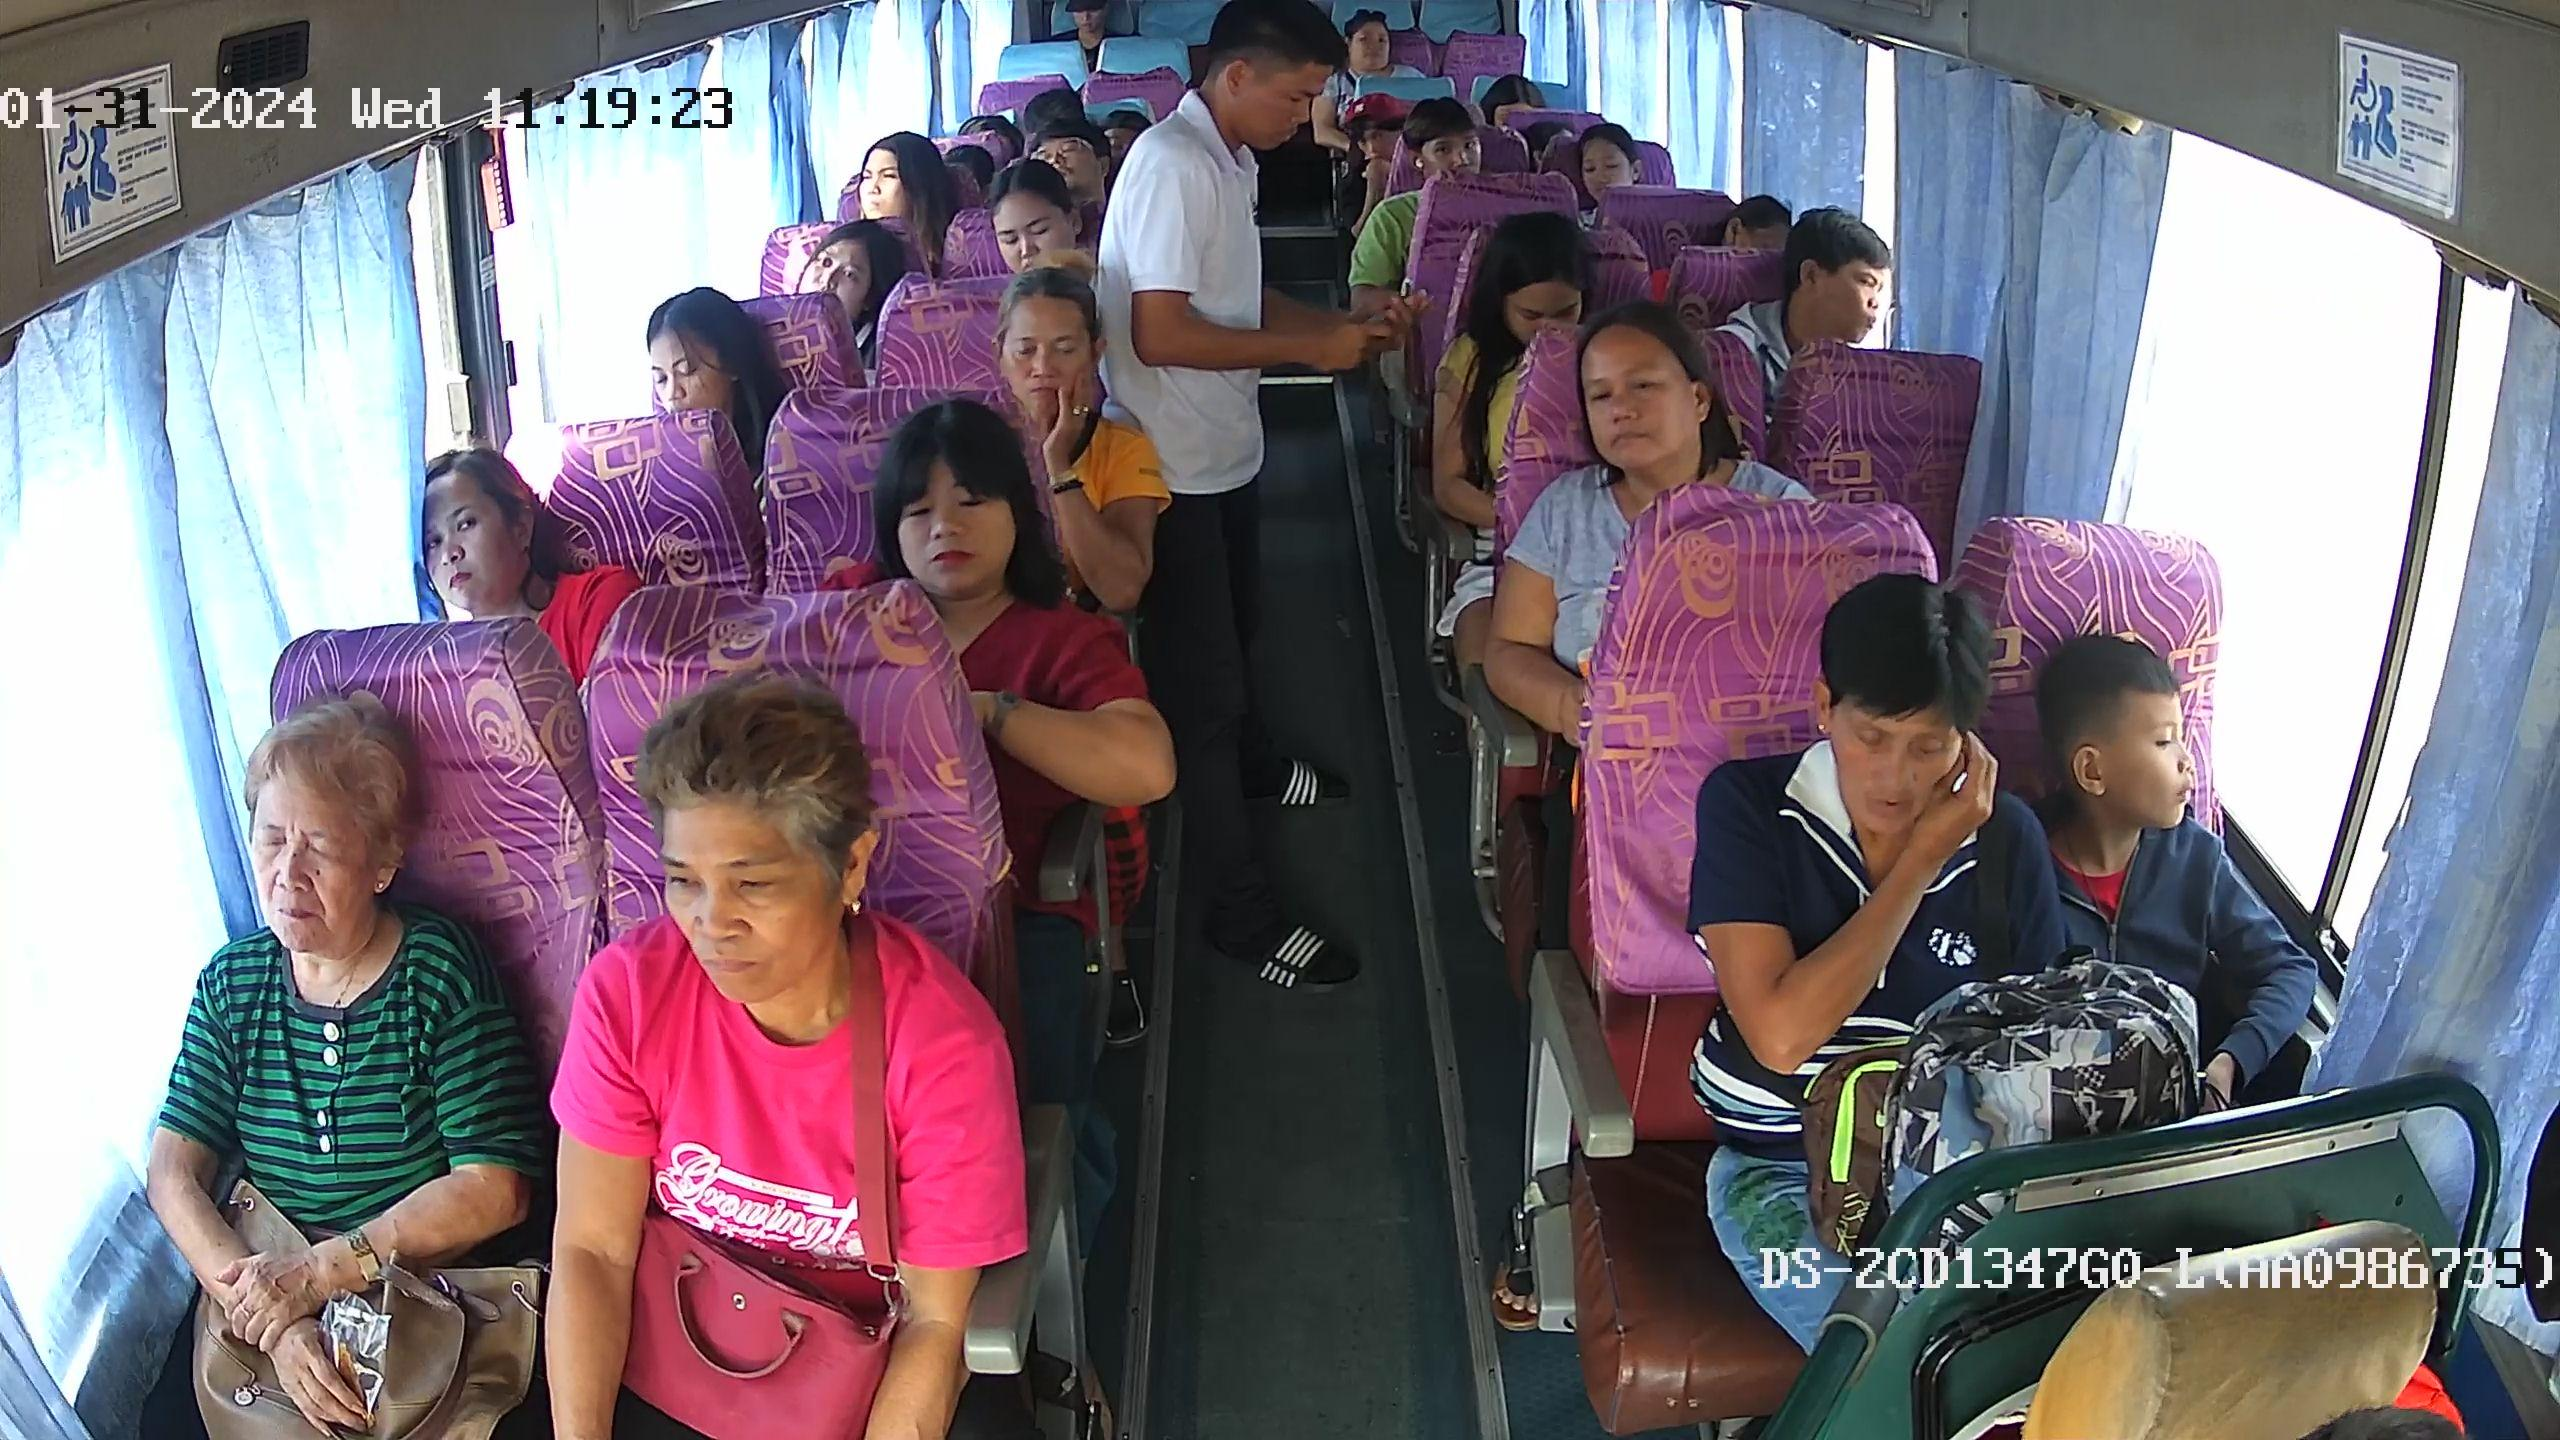

In [13]:
sample_data = test[3]
sample_question = sample_data["question"]
sample_answer = sample_data["answer"]
sample_image_path = sample_data["image"]
sample_image = Image.open(sample_image_path)

print(sample_question)
print(sample_answer)
sample_image

In [16]:
from transformers.image_utils import load_image

def image_text_generator(sample_data):
    question = sample_data["question"]
    messages = [
            {"role": "system", "content": "You are a Vision Language Model specialized in extracting data from images.Your task is to analyze the provided image of the inside of a bus and extract the relevant information."}, 
          {
              "role": "user",
              "content": [
                  {"type": "image"},
                  {"type": "text", "text": question}
              ]
          },
      ]
    
    text = processor.apply_chat_template(messages, add_generation_prompt=True)

    print(f"Prompt: {text}")
    print("-"*30)

    image_inputs_path = test[0]["image"]
    image_inputs = load_image(image_inputs_path)

    inputs = processor(
        text=text,
        images = image_inputs,
        return_tensors="pt"
    )
    #inputs = inputs.to("cuda:0")
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
    del inputs
    actual_answer = sample_data["answer"]
    return output_text[0], actual_answer
    

generated_text, actual_answer = image_text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Prompt: <|im_start|>System: <|endoftext|>
User:<image>How many people are sitting?<|endoftext|>
Assistant:
------------------------------
Generated Answer: System: 
User:<image>How many people are sitting?
Assistant: The number of people sitting in the bus is 10.
Actual Answer: The number of people sitting in the bus is 27.


## Test of finetuned SmolVLM on real images

In [ ]:
image_path = "people_sitting_in_bus.png"

def real_image_predictions(image_path, question):
    question = question
    messages = [
        {"role": "system", "content": "You are a Vision Language Model specialized in extracting data from images.Your task is to analyze the provided image of the inside of a bus and extract the relevant information."},
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": question}
                ]
            },
        ]
    
    text = processor.apply_chat_template(messages, add_generation_prompt=True)

    print(f"Prompt: {text}")
    print("-"*30)

    image_inputs = load_image(image_path)

    inputs = processor(
        text=text,
        images = image_inputs,
        return_tensors="pt"
    )
    inputs = inputs.to("cuda:0")

    generated_ids = model.generate(**inputs, max_new_tokens=128)

    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
    del inputs
    return output_text[0]
    

answer = real_image_predictions(image_path,"How many people are sitting?")
print(f"Answer: {answer}")

Prompt: <|im_start|>System: <|endoftext|>
User:<image>How many people are sitting?<|endoftext|>
Assistant:
------------------------------


Answer: System: 
User:<image>How many people are sitting?
Assistant: The number of people sitting in the bus is 4.


In [ ]:
image_path = "20171788-uhd_3840_2160_60fps.png"
answer = real_image_predictions(image_path, "How many people are sitting?")
print(f"Answer: {answer}")

Prompt: <|im_start|>System: <|endoftext|>
User:<image>How many people are sitting?<|endoftext|>
Assistant:
------------------------------
Answer: System: 
User:<image>How many people are sitting?
Assistant: The number of people sitting in the bus is 0.
